In [1]:
import fiona
import geopandas as gpd

In [7]:
# Register format drivers with a context manager
with fiona.drivers():

    # Open a file for reading. We'll call this the "source."
    with fiona.open('test/test_20110270.shp') as source:
        meta = source.meta
        geoms = []
        for feat in source:
            geoms.append(feat['geometry'])
    #/Users/shai/Google\ Drive/BatYam\ NY\ DRIVE/Articles/Article\ 0\ Rhythms\ of\ change/GIS/arcGIS\ online/test_20110270.shp

/Users/shai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FionaDeprecationWarning: Use fiona.Env() instead.
  


In [8]:
st_84 =  gpd.read_file('test/simulation_geopackage.gpkg',layer = 'buildings_3_tracts_wgs_84',driver='GPKG') #statistical Area

In [20]:
shp = geopandas.read_file('test/simulation_geopackage.gpkg',layername='geo_paack_test')

In [23]:
shp =  geopandas.read_file('test/simulation_geopackage.gpkg',layer = 'statistical_tract_wgs_84',driver='GPKG') #statistical Area

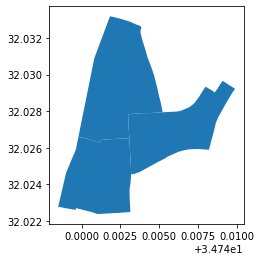

In [24]:
shp.plot()

In [5]:
source.meta

{'driver': 'ESRI Shapefile',
 'schema': {'properties': OrderedDict([('fid', 'float:20'),
               ('Area', 'float:24.15'),
               ('floors', 'int:10'),
               ('height', 'float:24.15'),
               ('bld_num', 'int:10'),
               ('bld_addres', 'str:254'),
               ('hebrew_adr', 'str:254'),
               ('project_nu', 'str:254'),
               ('units', 'int:10'),
               ('project_na', 'str:254'),
               ('project_ty', 'int:10'),
               ('status', 'str:254'),
               ('East', 'float:24.15'),
               ('North', 'float:24.15'),
               ('East_wgs84', 'float:24.15'),
               ('North_wgs8', 'float:24.15'),
               ('active', 'int:1'),
               ('start_date', 'date'),
               ('Comment', 'str:254'),
               ('end_date', 'date')]),
  'geometry': '3D Polygon'},
 'crs': {'init': 'epsg:2039'},
 'crs_wkt': 'PROJCS["Israel 1993 / Israeli TM Grid",GEOGCS["Israel 1993",DATUM["Israe

In [6]:
source

<closed Collection 'test/test_20110270.shp:test_20110270', mode 'r' at 0x7ffac6f0c128>

In [8]:
for fear in source:
    print(fear)

ValueError: I/O operation on closed collection

In [9]:
import geopandas as gpd
import pandas as pd
import folium
import branca
import requests
import json

from folium.features import GeoJson, GeoJsonTooltip, GeoJsonPopup

In [10]:
income = pd.read_csv(r"https://raw.githubusercontent.com/pri-data/50-states/master/data/income-counties-states-national.csv", dtype={"fips":str})
income['income-2015'] = pd.to_numeric(income['income-2015'], errors='coerce')

In [11]:
response = requests.get(r"https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/us-states.json")
data = response.json()
states = gpd.GeoDataFrame.from_features(data, crs='EPSG:4326')

states.head()

,geometry,name
0,"POLYGON ((-87.35930 35.00118, -85.60667 34.984...",Alabama
1,"MULTIPOLYGON (((-131.60202 55.11798, -131.5691...",Alaska
2,"POLYGON ((-109.04250 37.00026, -109.04798 31.3...",Arizona
3,"POLYGON ((-94.47384 36.50186, -90.15254 36.496...",Arkansas
4,"POLYGON ((-123.23326 42.00619, -122.37885 42.0...",California


In [12]:
response = requests.get('https://gist.githubusercontent.com/tvpmb/4734703/raw/b54d03154c339ed3047c66fefcece4727dfc931a/US%2520State%2520List')
abbrs = pd.read_json(response.text)

abbrs.head(3)

,name,alpha-2
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ


In [13]:
statesmerge = states.merge(abbrs, how='left', left_on='name', right_on='name')
statesmerge['geometry'] = statesmerge.geometry.simplify(.05)

statesmerge.head()

,geometry,name,alpha-2
0,"POLYGON ((-87.35930 35.00118, -85.60667 34.984...",Alabama,AL
1,"MULTIPOLYGON (((-131.60202 55.11798, -131.5691...",Alaska,AK
2,"POLYGON ((-109.04250 37.00026, -109.04798 31.3...",Arizona,AZ
3,"POLYGON ((-94.47384 36.50186, -90.15254 36.496...",Arkansas,AR
4,"POLYGON ((-123.23326 42.00619, -120.00186 41.9...",California,CA


In [14]:
statesmerge['medianincome'] = statesmerge.merge(income.groupby(by="state")[['state','income-2015']].median(),
                                                how='left', left_on='alpha-2', right_on='state')['income-2015']
statesmerge['change'] = statesmerge.merge(income.groupby(by="state")[['state','change']].median(),
                                          how='left', left_on='alpha-2', right_on='state')['change']

In [16]:
colormap = branca.colormap.LinearColormap(
    vmin=statesmerge['change'].quantile(0.0), 
    vmax=statesmerge['change'].quantile(1), 
    colors=['red','orange','lightblue','green','darkgreen'],
    caption="State Level Median County Household Income (%)",
)

In [17]:
m = folium.Map(location=[35.3, -97.6], zoom_start=4)

popup = GeoJsonPopup(
    fields=['name','change'],
    aliases=['State',"% Change"],
    localize=True,
    labels=True,
    style="background-color: yellow;",
)

tooltip = GeoJsonTooltip(
    fields=["name", "medianincome", "change"],
    aliases=["State:", "2015 Median Income(USD):", "Median % Change:"],
    localize=True,
    sticky=False,
    labels=True,
    style="""
        background-color: #F0EFEF;
        border: 2px solid black;
        border-radius: 3px;
        box-shadow: 3px;
    """,
    max_width=800,
)


g = folium.GeoJson(
    statesmerge,
    style_function=lambda x: {
        "fillColor": colormap(x["properties"]["change"])
        if x["properties"]["change"] is not None
        else "transparent",
        "color": "black",
        "fillOpacity": 0.4,
    },
    tooltip=tooltip,
    popup=popup
).add_to(m)

colormap.add_to(m)

m